### Data extraction

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Load the Excel file
df = pd.read_excel("Hackathon Database.xlsx")

# Remove empty rows (if any) where the energy-related columns are NaN
df = df.dropna(subset=df.columns[1:15], how='all')  # Drop rows where all energy columns are NaN

# Define the maximum allowable value for the machine readings (e.g., 1000000 as an example threshold)
MAX_VALUE_THRESHOLD = 1e5  # Set this threshold based on your domain knowledge

# Replace extreme values with NaN in the energy-related columns
df[df.columns[1:15]] = df[df.columns[1:15]].applymap(lambda x: x if x <= MAX_VALUE_THRESHOLD else None)

# Drop rows with any NaN values after replacing extreme values
df = df.dropna(subset=df.columns[1:15], how='any')

C:\Users\petri\AppData\Local\Temp\ipykernel_16628\2297420215.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df.columns[1:15]] = df[df.columns[1:15]].applymap(lambda x: x if x <= MAX_VALUE_THRESHOLD else None)


   Rolling_Avg_Consumption
1                56.118929
2                57.101607
3                57.723071
4                57.256518
5                57.319871


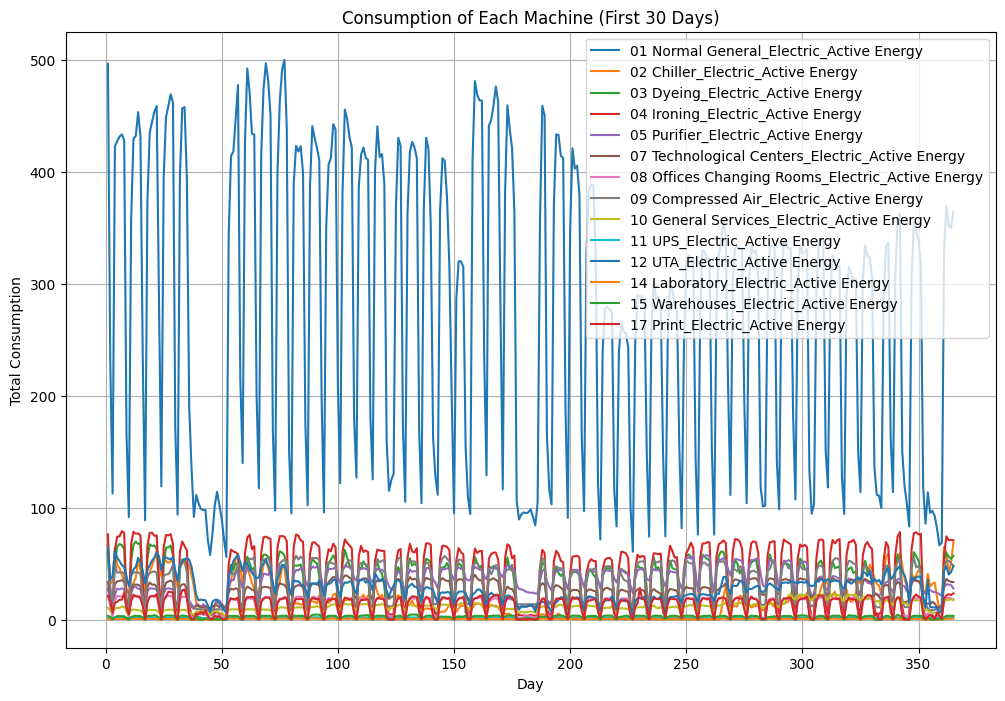

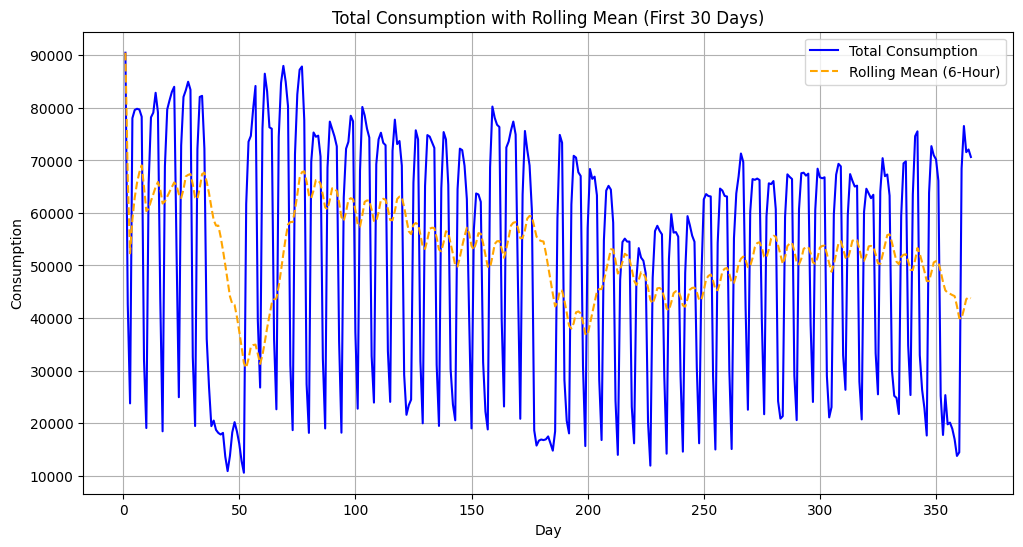

In [45]:
# Define the daily chunk size (excluding the first row which might be headers)
rows_per_day = 96

# Extract the relevant columns
energy_columns = df.loc[:, df.columns[1:15]]  # Columns B to O
power_factor_columns = df.loc[:, df.columns[19:33]]  # Columns T to AG
active_power_columns = df.loc[:, df.columns[36:50]]  # Columns AJ to AW

# Split the dataset into daily chunks and ensure each chunk is a copy
days = [df.iloc[i:i+rows_per_day].copy() for i in range(1, len(df), rows_per_day)] 

# Compute rolling average consumption with a 6-hour window (24 rows, since 15 min per row)
rolling_window = 24
for day in days:
    day['Rolling_Avg_Consumption'] = day.loc[:, df.columns[1:15]].mean(axis=1).rolling(window=rolling_window, min_periods=1).mean()

# Example: Display the first day's data and rolling average
first_day = days[0]
print(first_day[['Rolling_Avg_Consumption']].head())

#--------------------------------------------------------------------------------------------

# Graph the consumption for the first 30 days (for each machine)
plt.figure(figsize=(12, 8))

# Plot each machine's consumption for the first 30 days
for i, col in enumerate(df.columns[1:15]):  # Columns B to O (first 15 columns)
    consumption_data = [(day.loc[:, col].sum() / len(day.loc[:, col])) for day in days[:365]]  # Total daily consumption for each machine
    plt.plot(range(1, 366), consumption_data, label=col)  # Plot for each machine

plt.title('Consumption of Each Machine (First 30 Days)')
plt.xlabel('Day')
plt.ylabel('Total Consumption')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Now plot the total consumption with the rolling mean (for the first 30 days)
total_consumption = [sum(day.loc[:, df.columns[1:15]].sum(axis=1)) for day in days[:365]]  # Sum of all machines per day
rolling_mean = pd.Series(total_consumption).rolling(window=rolling_window, min_periods=1).mean()

# Plot the total consumption and rolling mean
plt.figure(figsize=(12, 6))
plt.plot(range(1, 366), total_consumption, label='Total Consumption', color='blue')
plt.plot(range(1, 366), rolling_mean, label='Rolling Mean (6-Hour)', color='orange', linestyle='--')

plt.title('Total Consumption with Rolling Mean (First 30 Days)')
plt.xlabel('Day')
plt.ylabel('Consumption')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

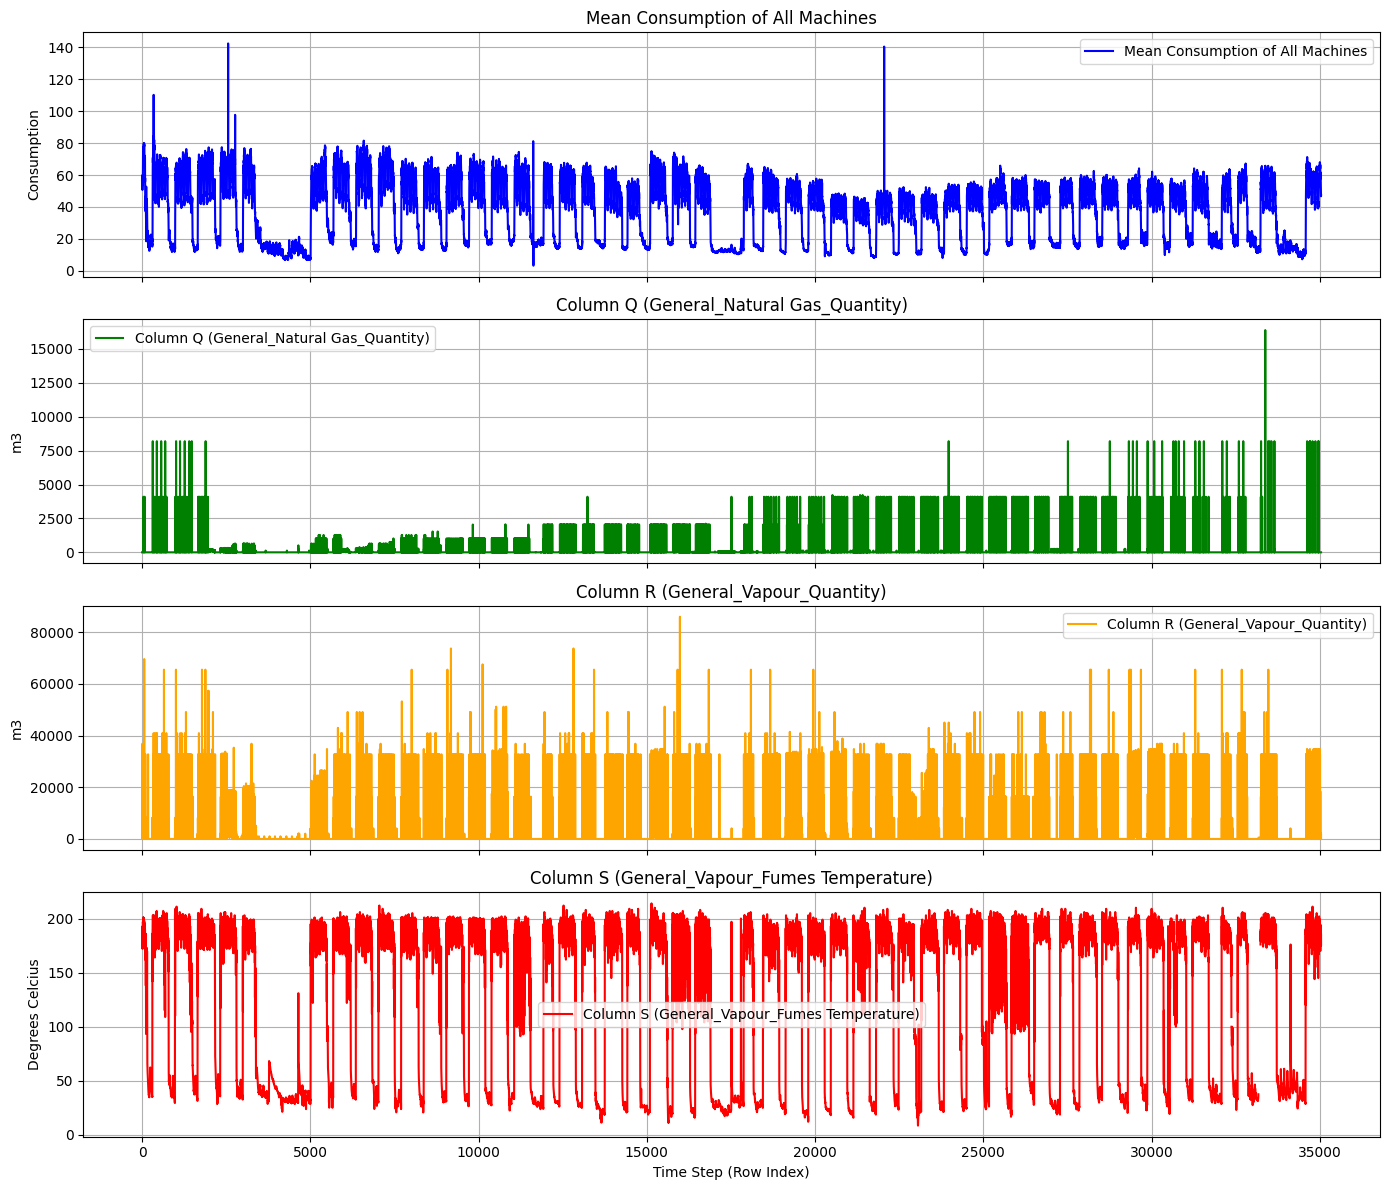

In [44]:

# Calculate the mean value of all measurements (energy-related columns) for each time step (row)
df['Mean_Consumption'] = df.loc[:, df.columns[1:15]].mean(axis=1)

# Create a figure with 4 subplots arranged vertically (1 column, 4 rows)
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot Mean Consumption (for all machines) in the first subplot
axs[0].plot(df.index[1:], df['Mean_Consumption'][1:], label='Mean Consumption of All Machines', color='blue')
axs[0].set_title('Mean Consumption of All Machines')
axs[0].set_ylabel('Consumption')
axs[0].grid(True)
axs[0].legend()

# Plot Column Q (Power Factor) in the second subplot
axs[1].plot(df.index[1:], df.iloc[1:, 16], label='Column Q (General_Natural Gas_Quantity)', color='green')
axs[1].set_title('Column Q (General_Natural Gas_Quantity)')
axs[1].set_ylabel('m3')
axs[1].grid(True)
axs[1].legend()

# Plot Column R (Power Factor) in the third subplot
axs[2].plot(df.index[1:], df.iloc[1:, 17], label='Column R (General_Vapour_Quantity)', color='orange')
axs[2].set_title('Column R (General_Vapour_Quantity)')
axs[2].set_ylabel('m3')
axs[2].grid(True)
axs[2].legend()

# Plot Column S (Power Factor) in the fourth subplot
axs[3].plot(df.index[1:], df.iloc[1:, 18], label='Column S (General_Vapour_Fumes Temperature)', color='red')
axs[3].set_title('Column S (General_Vapour_Fumes Temperature)')
axs[3].set_ylabel('Degrees Celcius')
axs[3].grid(True)
axs[3].legend()

# Set the common xlabel for all subplots
plt.xlabel('Time Step (Row Index)')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()